# Adversarial Autoencoders using Keras

In [1]:
import tensorflow
import numpy as np
import matplotlib.pyplot as plt
import keras

from keras.layers import Input, Dense, Activation, LeakyReLU
from keras.models import Sequential, Model
from keras.datasets import mnist
from keras.optimizers import Adam

%matplotlib inline


Using TensorFlow backend.


### Parameters and hyperparameters
rows, columns and channels dictate the properties of the input image
latent_size is the size of the "squished" or encoded representation
optimizer is just the optimizer
epochs & batch_size are just training hyperparameters

In [2]:
# just some variables

rows = 28
cols = 28
channels = 1
img_shape = (rows, cols, channels)
img_size = rows * cols * channels

latent_size = 16

optimizer = Adam(0.0002, 0.5)

epochs = 5000
batch_size = 128


Instructions for updating:
Colocations handled automatically by placer.


## Encoder
The encoder takes in a full sized image and compresses it to a smaller dimensionality, in this case it goes from img_size to latent_size

In [3]:
# create the encoder
def create_encoder(latent_size, img_size):
  model = Sequential()
  model.add(Dense(512, input_dim=img_size))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(512))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(latent_size))
  
  in_img = Input(shape=(img_size,))
  encoded_repr = model(in_img)
  
  return Model(in_img, encoded_repr)

## Decoder
The decoder takes in a compressed version of the image and tries to recreate the original image. We are using sigmoid(from 0-1) because we normalize the images from 0-1

In [4]:
# create the decoder
def create_decoder(latent_size, img_size):
  model = Sequential()
  model.add(Dense(512, input_dim=latent_size))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(512))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(img_size, activation='sigmoid'))
  
  encoded_repr = Input(shape=(latent_size,))
  out_img = model(encoded_repr)
  
  return Model(encoded_repr, out_img)

## Discriminator
This is the main part of *adversarial* autoencoders. The discriminator first learns how to tell whether an array belongs to a given distribution. The encoder then uses the discriminators output to try to make the encoded representation fit the given latent space.

In [5]:
# create the discriminator
def create_discriminator(latent_size):
  model = Sequential()
  model.add(Dense(512, input_dim=latent_size))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(256))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(1, activation='sigmoid'))
  
  encoded_repr = Input(shape=(latent_size,))
  probability = model(encoded_repr)
  
  return Model(encoded_repr, probability)

In [6]:
# putting it together

discriminator = create_discriminator(latent_size)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])

encoder = create_encoder(latent_size, img_size)
decoder = create_decoder(latent_size, img_size)

img = Input(shape=(img_size,))

encoded_repr = encoder(img)

decoded = decoder(encoded_repr)

discriminator.trainable = False

validity = discriminator(encoded_repr)

adversarial = Model(img, [decoded, validity])
adversarial.compile(loss=['mse', 'binary_crossentropy'], 
                          loss_weights=[0.999, 0.001], 
                          optimizer=optimizer)

### Getting and preprocessing the data
We only need the training set because AAEs don't care about classification(some do, but not this one)
Then we normalize the data to [0,1] and finally reshape the 28x28 images to 784x1 arrays

In [7]:
# get and preprocess data

(x_train, x_test), (_, _) = mnist.load_data()

x_train = x_train.astype(np.float64) / 255
x_train = x_train.reshape(x_train.shape[0], img_size)

In [8]:
# create real and fake "answers"
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

for epoch in range(epochs):
  # Select a random batch of images
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    imgs = x_train[idx]

    latent_fake = encoder.predict(imgs)
    
    # Here we generate the "TRUE" samples
    latent_real = np.random.normal(size=(batch_size, latent_size))
                      
    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(latent_real, valid)
    d_loss_fake = discriminator.train_on_batch(latent_fake, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ---------------------
    #  Train Generator
    # ---------------------

    # Train the generator
    g_loss = adversarial.train_on_batch(imgs, [imgs, valid])

    # Plot the progress (every 10th epoch)
    if epoch % 10 == 0:
        print ("%d [D loss: %f, acc: %.2f%%] [G loss: %f, mse: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0], g_loss[1]))

Instructions for updating:
Use tf.cast instead.


/home/sid/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.742987, acc: 40.62%] [G loss: 0.231862, mse: 0.231389]
10 [D loss: 0.187258, acc: 98.83%] [G loss: 0.098132, mse: 0.092561]
20 [D loss: 0.094409, acc: 99.61%] [G loss: 0.075750, mse: 0.070546]
30 [D loss: 0.072551, acc: 100.00%] [G loss: 0.074266, mse: 0.068497]
40 [D loss: 0.059966, acc: 99.22%] [G loss: 0.073480, mse: 0.066675]
50 [D loss: 0.052327, acc: 99.61%] [G loss: 0.069651, mse: 0.063308]
60 [D loss: 0.094691, acc: 96.88%] [G loss: 0.068589, mse: 0.061102]
70 [D loss: 0.140405, acc: 94.14%] [G loss: 0.067136, mse: 0.059950]
80 [D loss: 0.212980, acc: 90.23%] [G loss: 0.062664, mse: 0.055684]
90 [D loss: 0.510073, acc: 77.73%] [G loss: 0.065115, mse: 0.056860]
100 [D loss: 0.781409, acc: 62.11%] [G loss: 0.058465, mse: 0.052032]
110 [D loss: 0.749245, acc: 59.38%] [G loss: 0.054222, mse: 0.049585]
120 [D loss: 0.522527, acc: 64.45%] [G loss: 0.051952, mse: 0.047591]
130 [D loss: 0.391779, acc: 76.17%] [G loss: 0.049025, mse: 0.045397]
140 [D loss: 0.345438, acc: 88

1170 [D loss: 0.728896, acc: 53.52%] [G loss: 0.018960, mse: 0.018227]
1180 [D loss: 0.722466, acc: 56.25%] [G loss: 0.017444, mse: 0.016688]
1190 [D loss: 0.683003, acc: 57.03%] [G loss: 0.016291, mse: 0.015536]
1200 [D loss: 0.682778, acc: 55.08%] [G loss: 0.019172, mse: 0.018417]
1210 [D loss: 0.634898, acc: 64.84%] [G loss: 0.016712, mse: 0.015893]
1220 [D loss: 0.662134, acc: 58.59%] [G loss: 0.018195, mse: 0.017417]
1230 [D loss: 0.655373, acc: 60.16%] [G loss: 0.016818, mse: 0.016029]
1240 [D loss: 0.670907, acc: 59.38%] [G loss: 0.018490, mse: 0.017733]
1250 [D loss: 0.648680, acc: 62.11%] [G loss: 0.018194, mse: 0.017446]
1260 [D loss: 0.665655, acc: 62.89%] [G loss: 0.017143, mse: 0.016349]
1270 [D loss: 0.701164, acc: 53.91%] [G loss: 0.017648, mse: 0.016882]
1280 [D loss: 0.688628, acc: 60.16%] [G loss: 0.017376, mse: 0.016592]
1290 [D loss: 0.696635, acc: 55.47%] [G loss: 0.017597, mse: 0.016848]
1300 [D loss: 0.665083, acc: 63.28%] [G loss: 0.018596, mse: 0.017842]
1310 [

2330 [D loss: 0.532630, acc: 81.25%] [G loss: 0.014122, mse: 0.013163]
2340 [D loss: 0.532421, acc: 80.86%] [G loss: 0.014464, mse: 0.013485]
2350 [D loss: 0.564009, acc: 76.17%] [G loss: 0.015999, mse: 0.015086]
2360 [D loss: 0.570544, acc: 75.00%] [G loss: 0.015588, mse: 0.014658]
2370 [D loss: 0.541322, acc: 80.08%] [G loss: 0.015168, mse: 0.014183]
2380 [D loss: 0.533569, acc: 81.64%] [G loss: 0.014534, mse: 0.013568]
2390 [D loss: 0.547790, acc: 80.47%] [G loss: 0.016332, mse: 0.015376]
2400 [D loss: 0.535053, acc: 78.52%] [G loss: 0.014638, mse: 0.013672]
2410 [D loss: 0.525264, acc: 83.59%] [G loss: 0.015187, mse: 0.014223]
2420 [D loss: 0.511433, acc: 80.47%] [G loss: 0.016632, mse: 0.015629]
2430 [D loss: 0.550776, acc: 75.39%] [G loss: 0.015726, mse: 0.014776]
2440 [D loss: 0.526011, acc: 78.52%] [G loss: 0.014814, mse: 0.013849]
2450 [D loss: 0.557317, acc: 75.39%] [G loss: 0.017153, mse: 0.016231]
2460 [D loss: 0.542913, acc: 75.78%] [G loss: 0.015712, mse: 0.014731]
2470 [

3490 [D loss: 0.409127, acc: 86.33%] [G loss: 0.014899, mse: 0.013463]
3500 [D loss: 0.413823, acc: 83.20%] [G loss: 0.012527, mse: 0.011082]
3510 [D loss: 0.400851, acc: 84.77%] [G loss: 0.014257, mse: 0.012862]
3520 [D loss: 0.463039, acc: 78.52%] [G loss: 0.015337, mse: 0.014059]
3530 [D loss: 0.454348, acc: 78.91%] [G loss: 0.014990, mse: 0.013699]
3540 [D loss: 0.407545, acc: 86.72%] [G loss: 0.015455, mse: 0.014108]
3550 [D loss: 0.431321, acc: 81.25%] [G loss: 0.013265, mse: 0.011947]
3560 [D loss: 0.462972, acc: 80.86%] [G loss: 0.014925, mse: 0.013582]
3570 [D loss: 0.446021, acc: 81.25%] [G loss: 0.014109, mse: 0.012751]
3580 [D loss: 0.439404, acc: 81.64%] [G loss: 0.013859, mse: 0.012461]
3590 [D loss: 0.445331, acc: 82.42%] [G loss: 0.013548, mse: 0.012162]
3600 [D loss: 0.442851, acc: 82.42%] [G loss: 0.015422, mse: 0.014048]
3610 [D loss: 0.442226, acc: 80.86%] [G loss: 0.014893, mse: 0.013518]
3620 [D loss: 0.430907, acc: 82.03%] [G loss: 0.014291, mse: 0.012957]
3630 [

4650 [D loss: 0.449417, acc: 79.69%] [G loss: 0.013723, mse: 0.012247]
4660 [D loss: 0.406505, acc: 87.11%] [G loss: 0.013497, mse: 0.011995]
4670 [D loss: 0.436085, acc: 82.42%] [G loss: 0.013411, mse: 0.011937]
4680 [D loss: 0.426991, acc: 82.03%] [G loss: 0.013257, mse: 0.011776]
4690 [D loss: 0.419740, acc: 82.42%] [G loss: 0.014718, mse: 0.013252]
4700 [D loss: 0.441413, acc: 83.20%] [G loss: 0.014567, mse: 0.013193]
4710 [D loss: 0.424658, acc: 83.20%] [G loss: 0.012528, mse: 0.011058]
4720 [D loss: 0.403446, acc: 85.16%] [G loss: 0.013718, mse: 0.012252]
4730 [D loss: 0.461795, acc: 80.86%] [G loss: 0.013740, mse: 0.012319]
4740 [D loss: 0.448218, acc: 78.52%] [G loss: 0.013188, mse: 0.011755]
4750 [D loss: 0.426242, acc: 83.59%] [G loss: 0.013579, mse: 0.012104]
4760 [D loss: 0.398558, acc: 84.77%] [G loss: 0.013627, mse: 0.012119]
4770 [D loss: 0.443667, acc: 79.69%] [G loss: 0.013891, mse: 0.012541]
4780 [D loss: 0.388996, acc: 84.77%] [G loss: 0.013039, mse: 0.011483]
4790 [

Ideally the accuracy of the discriminator would be ~50% (due to just guessing) but its not perfect

## Sampling latent space & reconstructions

In [9]:
# Sample images

def sample_latents():
    fig = plt.figure(figsize=(9,13))
    columns = 4
    rows = 5
    
    zs = np.random.normal(size=(columns*rows +1, latent_size))
    decoded = decoder.predict(zs)
    
    for i in range(1,columns*rows + 1):
        fig.add_subplot(rows,columns,i)
        img = decoded[i].reshape(28, 28)
        plt.imshow(img, cmap="gray")
        
    plt.show()
        
    
    
def sample_reconstructions():
    fig = plt.figure(figsize=(9,13))
    columns = 4
    rows = 5
    
    idx = np.random.randint(0, x_train.shape[0], 10)
    imgs = x_train[idx]
    reconstructions = adversarial.predict(imgs)[0]
    
    for i in range(0, columns*rows,2):
        fig.add_subplot(rows,columns,i+1)
        img1 = imgs[i//2].reshape(28,28)
        plt.imshow(img1,cmap="gray")
        fig.add_subplot(rows,columns,i+2)
        img2 = reconstructions[i//2].reshape(28,28)
        plt.imshow(img2,cmap="gray")

    plt.show()

## Visualising gaussian examples
The model is not that great at transforming latent samples into images and its easy to see its flaws as most of the images are not very clear

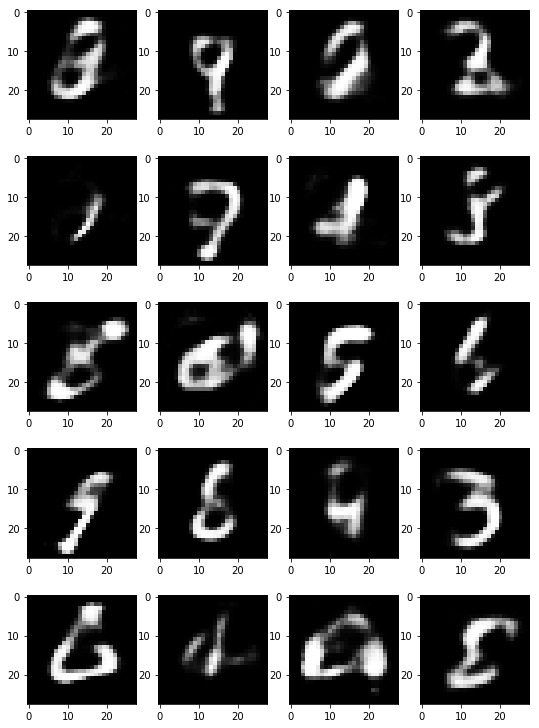

In [10]:
sample_latents()

## Visualising Reconstruction
The reconstruction turned out to be pretty good and it is pretty easy to distinguish the reconstructed image, except for the occasional 4 and 9

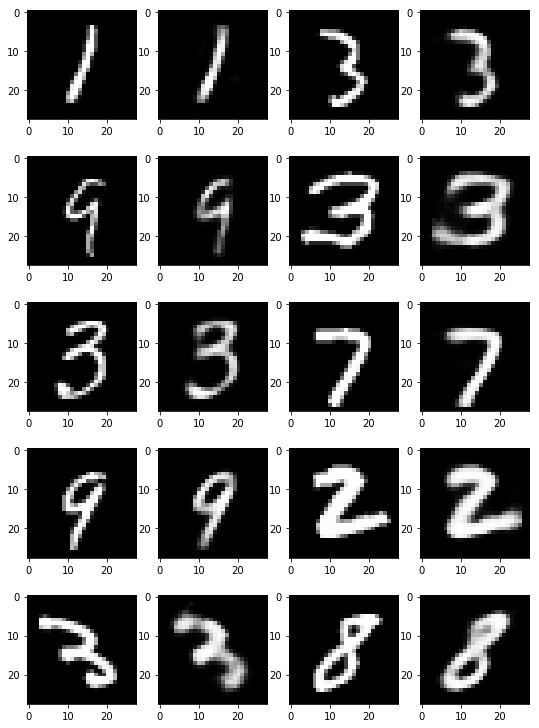

In [12]:
sample_reconstructions()

# Visualising the latent space and examples
For this we will use t-SNE to view where certain numbers are placed in latent space.
We could create a classification network to identify which number is which but we are already given the labels.